# GARCH Model

- While autoregressive models are good at predicting univariate time series data with trends (ARIMA) and seasonality (SARIMA), they assume that the variance of the errors does not change over time.

- In time series where varinace changes over time due to volatility, the series is said to be heteroscedastic (typically financial data). 

- Heteroscedastic time series can sometimes be adjusted by transforming the data (log-transform, power transform).

- If the change in variance can be correlated over time, then it can be modelled using an AR process like ARCH or GARCH.

In [1]:
#!pip install arch

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
daily_cases_india = pd.read_csv('../../cleaned_datasets/india/daily_cases_india.csv', parse_dates=['Date'], index_col=0)
cum_cases_india = pd.read_csv('../../cleaned_datasets/india/cum_cases_india.csv', parse_dates=['Date'])

In [4]:
cum_cases_india

,Date,Confirmed,Deaths,Recovered,Active
0,2020-01-30,1.0,0.0,0.0,0.0
1,2020-01-31,1.0,0.0,0.0,0.0
2,2020-02-01,1.0,0.0,0.0,0.0
3,2020-02-02,2.0,0.0,0.0,0.0
4,2020-02-03,3.0,0.0,0.0,0.0
...,...,...,...,...,...
617,2021-10-08,33935309.0,450375.0,0.0,0.0
618,2021-10-09,33953475.0,450589.0,0.0,0.0
619,2021-10-10,33971607.0,450782.0,0.0,0.0
620,2021-10-11,33985920.0,450963.0,0.0,0.0


In [5]:
daily_cases_india

,Date,Confirmed,Deaths,Recovered,Active
0,2020-01-30,1.0,0.0,0.0,0.0
1,2020-01-31,0.0,0.0,0.0,0.0
2,2020-02-01,0.0,0.0,0.0,0.0
3,2020-02-02,1.0,0.0,0.0,0.0
4,2020-02-03,1.0,0.0,0.0,0.0
...,...,...,...,...,...
617,2021-10-08,19740.0,248.0,0.0,0.0
618,2021-10-09,18166.0,214.0,0.0,0.0
619,2021-10-10,18132.0,193.0,0.0,0.0
620,2021-10-11,14313.0,181.0,0.0,0.0


In [6]:
daily_cases_india.iloc[0] = cum_cases_india.iloc[0]

In [7]:
daily_cases_india.to_csv('../../cleaned_datasets/india/daily_cases_india.csv')
daily_cases_india

,Date,Confirmed,Deaths,Recovered,Active
0,2020-01-30,1.0,0.0,0.0,0.0
1,2020-01-31,0.0,0.0,0.0,0.0
2,2020-02-01,0.0,0.0,0.0,0.0
3,2020-02-02,1.0,0.0,0.0,0.0
4,2020-02-03,1.0,0.0,0.0,0.0
...,...,...,...,...,...
617,2021-10-08,19740.0,248.0,0.0,0.0
618,2021-10-09,18166.0,214.0,0.0,0.0
619,2021-10-10,18132.0,193.0,0.0,0.0
620,2021-10-11,14313.0,181.0,0.0,0.0


In [8]:
daily_confirmed = daily_cases_india.drop(['Recovered', 'Deaths', 'Active'], axis=1)
daily_confirmed

,Date,Confirmed
0,2020-01-30,1.0
1,2020-01-31,0.0
2,2020-02-01,0.0
3,2020-02-02,1.0
4,2020-02-03,1.0
...,...,...
617,2021-10-08,19740.0
618,2021-10-09,18166.0
619,2021-10-10,18132.0
620,2021-10-11,14313.0


### Plotting the cumulative cases over time

In [9]:
daily_confirmed.plot(figsize=(6,6))

ValueError: view limit minimum -38854.65 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

### Checking for stationarity

We will plot the rolling average of the plot at different window sizes and compare the plots to see if the mean is constant.

We will also plot the rolling standard deviation to check for stationarity

In [10]:
daily_ts = daily_confirmed.set_index(['Date'])['Confirmed']

def roll_stats(ts, window, title):
    ''' Function to find rolling mean and rolling std dev and plot them'''
    rollmean = ts.rolling(window = window).mean()
    rollstd = ts.rolling(window = window).std()
    print(rollmean, rollstd)

    plt.figure(figsize=(8,8))
    close = plt.plot(ts, color = 'blue', label = 'Original')
    mean = plt.plot(rollmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rollstd, color = 'green', label = 'Rolling Standard Dev')
    plt.legend(loc = 'best')
    plt.title(title)
    plt.show()

Date
2020-01-30             NaN
2020-01-31             NaN
2020-02-01             NaN
2020-02-02             NaN
2020-02-03             NaN
                  ...     
2021-10-08    20606.857143
2021-10-09    19938.857143
2021-10-10    19557.857143
2021-10-11    18981.714286
2021-10-12    18551.714286
Name: Confirmed, Length: 622, dtype: float64 Date
2020-01-30            NaN
2020-01-31            NaN
2020-02-01            NaN
2020-02-02            NaN
2020-02-03            NaN
                 ...     
2021-10-08    1722.036143
2021-10-09    1614.042691
2021-10-10    1690.146091
2021-10-11    2609.466977
2021-10-12    2872.773556
Name: Confirmed, Length: 622, dtype: float64


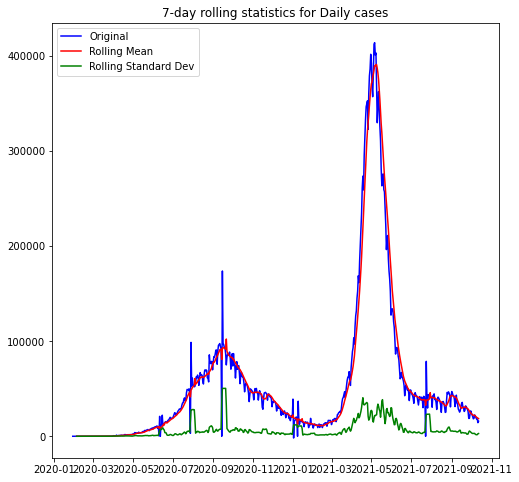

In [11]:
# 7-day moving average
roll_stats(daily_ts, 7, '7-day rolling statistics for Daily cases')

Date
2020-01-30             NaN
2020-01-31             NaN
2020-02-01             NaN
2020-02-02             NaN
2020-02-03             NaN
                  ...     
2021-10-08    26510.933333
2021-10-09    25950.700000
2021-10-10    25442.566667
2021-10-11    24966.633333
2021-10-12    24585.600000
Name: Confirmed, Length: 622, dtype: float64 Date
2020-01-30            NaN
2020-01-31            NaN
2020-02-01            NaN
2020-02-02            NaN
2020-02-03            NaN
                 ...     
2021-10-08    5185.596444
2021-10-09    5147.605410
2021-10-10    5141.743993
2021-10-11    5489.323974
2021-10-12    5717.082826
Name: Confirmed, Length: 622, dtype: float64


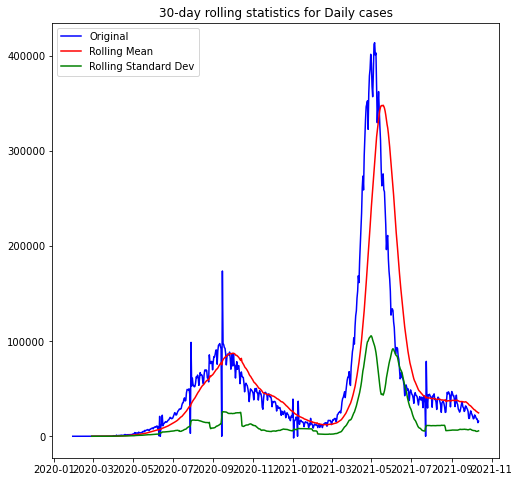

In [12]:
# 30-day moving average
roll_stats(daily_ts, 30, '30-day rolling statistics for Daily cases')

From visual inspection, the time series is not stationary and needs to be differenced.

### Augmented Dickey-Fuller Test

- $H_0:$ Presence of a unit root (Time Series is not stationary)
- $H_1:$ There is no unit root (Time-series is stationary)

$DF_t = \frac{\gamma}{SE(\gamma)}$

The more negative $DF_t$, the stronger evidence for rejecting $H_0$.   
If p-value < 0.001, we can reject $H_0$ and say that the time series is stationary

In [13]:
from statsmodels.tsa.stattools import adfuller

def run_dicky_fuller(ts):
  '''Function to run Augmented Dicky Fuller test on the passed time series and report the statistics from the test'''
  print("Observations of Dickey-fuller test")
  dftest = adfuller(ts,autolag='AIC')
  dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])

  for key,value in dftest[4].items():
      dfoutput['critical value (%s)'%key]= value
  print(dfoutput)

run_dicky_fuller(daily_ts)

Observations of Dickey-fuller test
Test Statistic                  -3.842259
p-value                          0.002503
#lags used                      15.000000
number of observations used    606.000000
critical value (1%)             -3.441187
critical value (5%)             -2.866321
critical value (10%)            -2.569316
dtype: float64


Since the p-value > 0.001, the time series is not stationary and it needs to be transformed/differenced.

### Check for trend and seasonality

<Figure size 432x288 with 0 Axes>

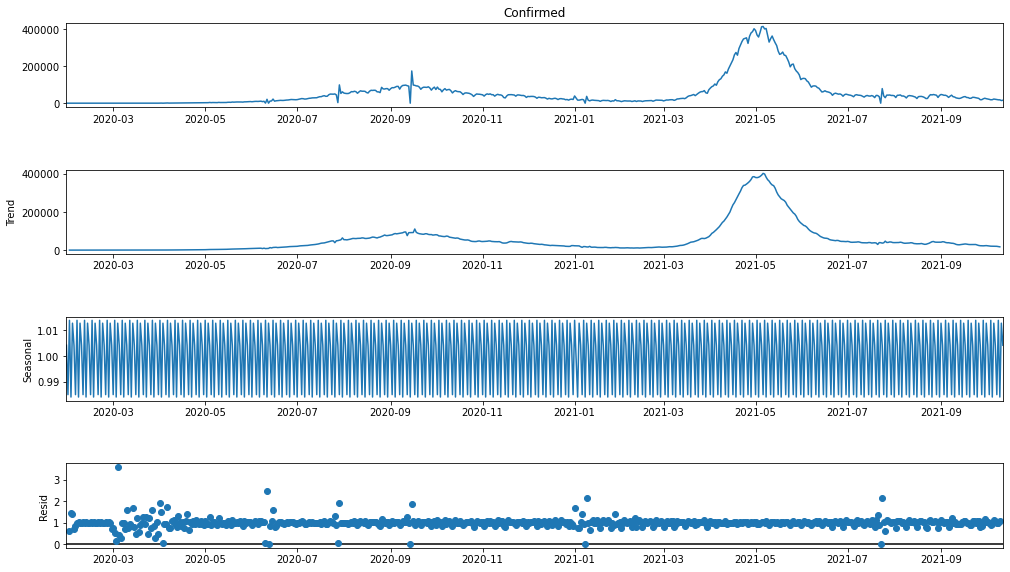

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decomp_mult(ts, period):
    decomp = seasonal_decompose(ts, model='multiplicable', period=period)
    fig = plt.figure()  
    fig = decomp.plot() 
    fig.set_size_inches(16, 9)
    
# Some data are incorrect and < 0
daily_pos = daily_ts[daily_ts.index[daily_ts >= 0]]

# Add a constant for the 0's
const_added = daily_pos + 1

# Period = 5
decomp_mult(const_added, 5)

<Figure size 432x288 with 0 Axes>

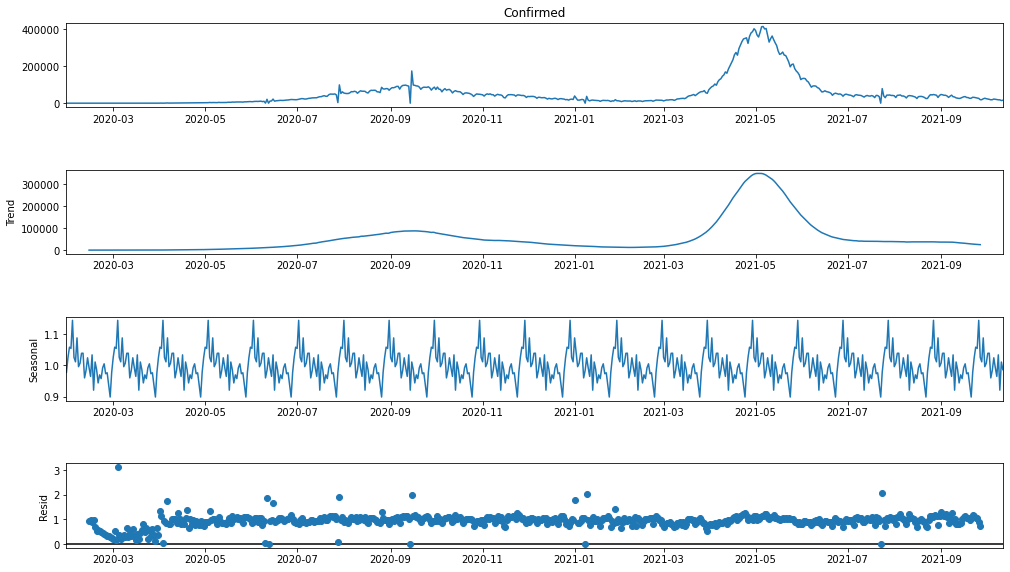

In [15]:
# Period = 30
decomp_mult(const_added, 30)

<Figure size 432x288 with 0 Axes>

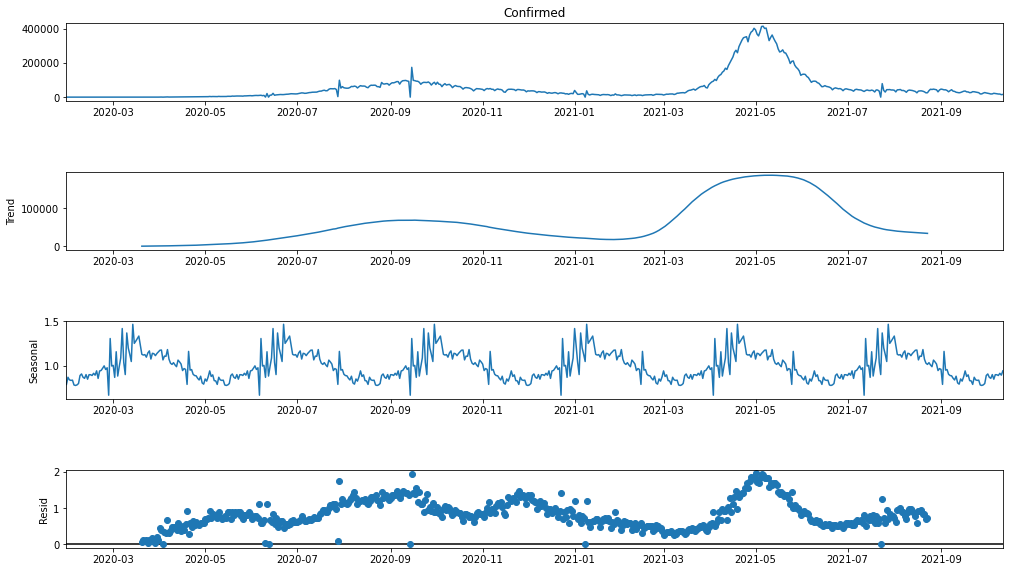

In [16]:
# Period = 100
decomp_mult(const_added, 100)

As we can see, there are two peaks in the trend, and noticable seasonality.

### First-order differencing

The time series is differenced to try and make the mean constant.

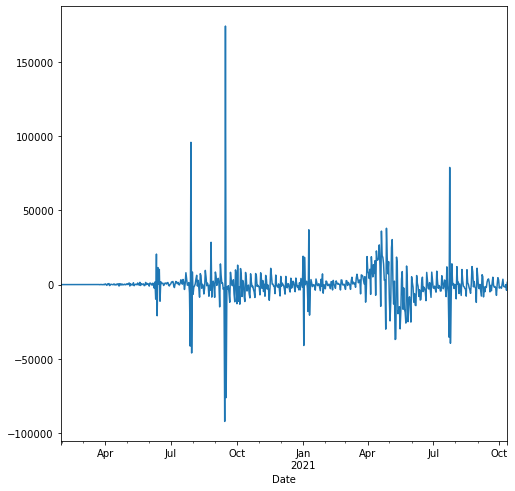

In [17]:
daily_ts_diff_1 = daily_ts - daily_ts.shift(1)
daily_ts_diff_1.plot(figsize=(8,8))

Date
2020-01-30           NaN
2020-01-31           NaN
2020-02-01           NaN
2020-02-02           NaN
2020-02-03           NaN
                 ...    
2021-10-08   -659.142857
2021-10-09   -668.000000
2021-10-10   -381.000000
2021-10-11   -576.142857
2021-10-12   -430.000000
Name: Confirmed, Length: 622, dtype: float64 Date
2020-01-30            NaN
2020-01-31            NaN
2020-02-01            NaN
2020-02-02            NaN
2020-02-03            NaN
                 ...     
2021-10-08    2093.571703
2021-10-09    2097.907847
2021-10-10    2014.201744
2021-10-11    2294.999886
2021-10-12    2403.967623
Name: Confirmed, Length: 622, dtype: float64


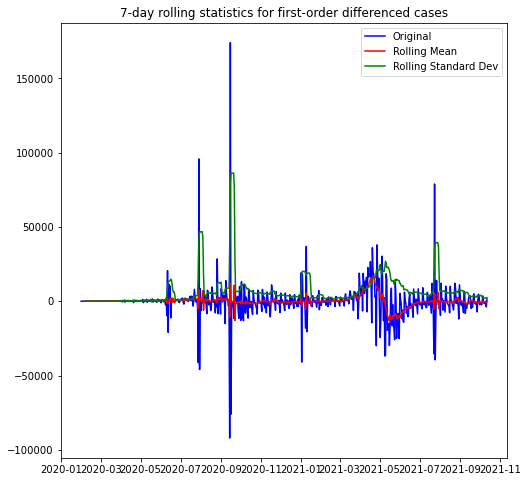

Observations of Dickey-fuller test
Test Statistic                  -4.673828
p-value                          0.000094
#lags used                      19.000000
number of observations used    601.000000
critical value (1%)             -3.441278
critical value (5%)             -2.866361
critical value (10%)            -2.569338
dtype: float64


In [18]:
# 7-day moving average
roll_stats(daily_ts_diff_1, 7, '7-day rolling statistics for first-order differenced cases')

run_dicky_fuller(daily_ts_diff_1.dropna())

### Second-order differencing

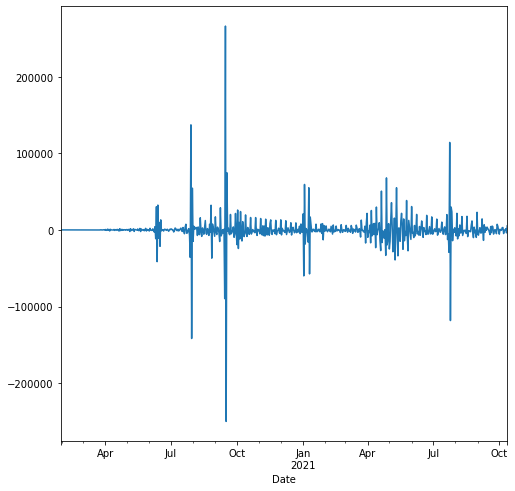

In [19]:
daily_ts_diff_2 = daily_ts_diff_1 - daily_ts_diff_1.shift(1)
daily_ts_diff_2.plot(figsize=(8,8))

Date
2020-01-30           NaN
2020-01-31           NaN
2020-02-01           NaN
2020-02-02           NaN
2020-02-03           NaN
                 ...    
2021-10-08    122.285714
2021-10-09     -8.857143
2021-10-10    287.000000
2021-10-11   -195.142857
2021-10-12    146.142857
Name: Confirmed, Length: 622, dtype: float64 Date
2020-01-30            NaN
2020-01-31            NaN
2020-02-01            NaN
2020-02-02            NaN
2020-02-03            NaN
                 ...     
2021-10-08    2655.128981
2021-10-09    2635.157012
2021-10-10    2682.595758
2021-10-11    3099.625323
2021-10-12    3594.388331
Name: Confirmed, Length: 622, dtype: float64


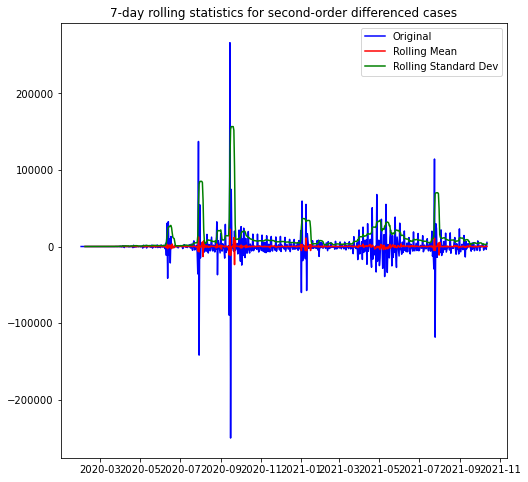

In [20]:
# 7-day moving average
roll_stats(daily_ts_diff_2, 7, '7-day rolling statistics for second-order differenced cases')

The TS of second-prder differenced data looks stationary. As we can see, the volatility is conditional and it looks like a good candidate for a GARCH model.

## GARCH Model

- $GARCH(p, q)$
    - $p$: number of lag residual errors
    - $q$: number of lag variances

- Formula
    - $a_t = \varepsilon_t \sqrt{\omega + \sum_{i=1}^{p} \alpha_i a_{t-i}^2  + \sum_{i=1}^{q} \beta_i \sigma_{t-i}^2 }$

#### ACF and PACF plots

- To find the parameters of the GARCH model

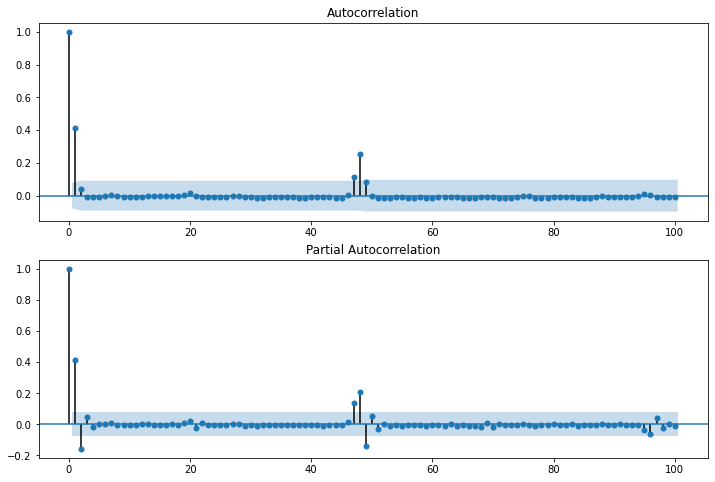

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(daily_ts_diff_1.dropna()**2, lags=100, ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(daily_ts_diff_1.dropna()**2, lags=100, ax = ax2)

Possible model: GARCH(2, 2)

### Train-test split

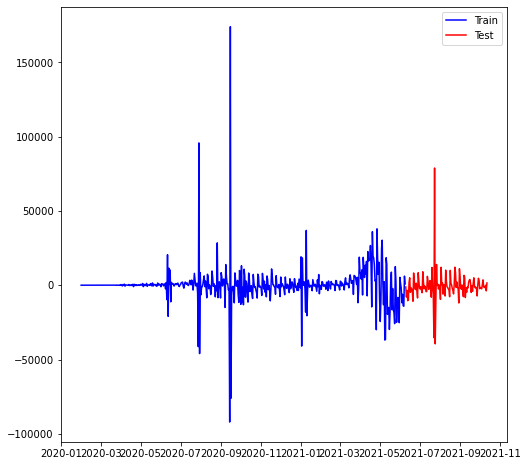

In [22]:
percent_80 = int(len(daily_ts_diff_1)*0.8)

train = daily_ts_diff_1.iloc[:percent_80].dropna()
test = daily_ts_diff_1.iloc[percent_80:]

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)

ax.plot(train, color = 'blue', label = 'Train')
ax.plot(test, color = 'red', label = 'Test')
ax.legend(loc = 'best')
plt.show()

In [23]:
from arch import arch_model 

# model = arch_model(train, mean='Zero', vol='GARCH', p=2, q=2)
model = arch_model(train, p=1, q=1)
model_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5590.767278937254
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5123.835595188404
Iteration:      3,   Func. Count:     17,   Neg. LLF: 5123.816312371089
Iteration:      4,   Func. Count:     22,   Neg. LLF: 5123.815882412373
Iteration:      5,   Func. Count:     27,   Neg. LLF: 5123.815874386014
Iteration:      6,   Func. Count:     32,   Neg. LLF: 5123.815843910506
Iteration:      7,   Func. Count:     37,   Neg. LLF: 5123.815684550753
Iteration:      8,   Func. Count:     42,   Neg. LLF: 5123.814885083717
Iteration:      9,   Func. Count:     47,   Neg. LLF: 5123.810945207872
Iteration:     10,   Func. Count:     52,   Neg. LLF: 5123.792625641009
Iteration:     11,   Func. Count:     57,   Neg. LLF: 5123.728137153884
Iteration:     12,   Func. Count:     62,   Neg. LLF: 5123.693975794153
Iteration:     13,   Func. Count:     67,   Neg. LLF: 5123.693970349201
Iteration:     14,   Func. Count:     73,   Neg. LLF: 5123.69395

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.833e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [24]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              Confirmed   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5123.69
Distribution:                  Normal   AIC:                           10255.4
Method:            Maximum Likelihood   BIC:                           10272.2
                                        No. Observations:                  496
Date:                Mon, Dec 13 2021   Df Residuals:                      495
Time:                        18:11:48   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu           285.8584    267.642      1.068      0.285 [-2.387e+02,8.104e+02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.6667e+06  1.139e+06      3.219  1.287e-03 [1.434e+06,5.899e+06]
alpha[1]       0.2916  5.926e-02      4.920  8.643e-07     [  0.175,  0.408]
beta[1]        0.7084      0.106      6.699  2.093e-11     [  0.501,  0.916]
============================================================================

Covariance estimator: robust
"""

/Users/vish/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


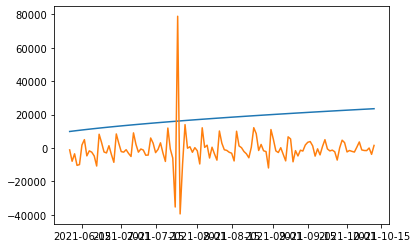

In [25]:
yhat = model_fit.forecast(horizon=len(test))

yhatvar = pd.DataFrame(pd.DataFrame(test).reset_index()['Date'])

yhatvar['var'] = np.sqrt(yhat.variance.values[-1, :])

plt.plot(yhatvar['Date'], yhatvar['var'])
plt.plot(test)
plt.show()